In [378]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
import dnest4 as dn4
from pyblobby3d import PostBlobby3D
from pyblobby3d import SpectralModel
from scipy.interpolate import RegularGridInterpolator

In [379]:
# path to the directory containing the data and the output
dir_path = '/Users/scol0322/Documents/processed/485885-windowed/'
data_file = '/Users/scol0322/Documents/raw-data/485885/485885_8_Y13SAR1_P007_15T010_2013_03_05-2013_03_17_1_comp.fits'

# check if directories and files exist
if not os.path.exists(dir_path):
    raise FileNotFoundError(f"Directory not found: {dir_path}")
if not os.path.exists(data_file):
    raise FileNotFoundError(f"Velocity data file not found: {data_file}")

DNest post processing call only works if you call it from within the directory.

Save current dir, hop there, call DNest, hop back.

In [380]:
# save current directory
original_dir = os.getcwd()

def run_dnest4_postprocessing(dir_path):
    """run dnest4 postprocessing in the specified directory."""
    try:
        os.chdir(dir_path)
        dn4.postprocess()
    finally:
        os.chdir(original_dir)

#run_dnest4_postprocessing(dir_path)

In [381]:
# function for reading the options file
# specifically the lines and global LSF FWHM (not really used)
def read_options_file(options_file):
    """read the options file to extract emission lines and nlines."""
    lines = []
    lsf_fwhm = None
    
    if not os.path.exists(options_file):
        print(f"Warning: Options file not found: {options_file}")
        return [], 0, None
    
    try:
        with open(options_file, 'r') as f:
            for line in f:
                # skip comments and empty lines
                if line.strip().startswith('#') or not line.strip():
                    continue
                
                # remove inline comments
                if '#' in line:
                    line = line[:line.index('#')]
                
                parts = line.strip().split()
                if not parts:
                    continue
                
                if parts[0].upper() == 'LINE':
                    # parse line definition: LINE main_wavelength [coupled_wavelength1 ratio1 ...]
                    line_data = []
                    for i, part in enumerate(parts[1:]):
                        try:
                            line_data.append(float(part))
                        except ValueError:
                            break
                    
                    if line_data:
                        lines.append(line_data)
                
                elif parts[0].upper() == 'LSFFWHM':
                    try:
                        lsf_fwhm = float(parts[1])
                    except (ValueError, IndexError):
                        pass
    except Exception as e:
        print(f"Error reading options file: {e}")
        return [], 0, None
    
    nlines = len(lines)
    return lines, nlines, lsf_fwhm

In [382]:
# function for reading the metadata file
# specifically the waveranges and the coords
def read_metadata_file(metadata_file):
    """read metadata file to get resolution, calculate lsf_fwhm, and extract coordinate info."""
    wavelength_windows = []
    coord_info = {}
    
    if not os.path.exists(metadata_file):
        print(f"Warning: Metadata file not found: {metadata_file}")
        return [], {}
    
    try:
        with open(metadata_file, 'r') as f:
            for line in f:
                # skip comments and empty lines
                if line.strip().startswith('#') or not line.strip():
                    continue
                
                # remove inline comments
                if '#' in line:
                    line = line[:line.index('#')]
                
                parts = line.strip().split()
                if not parts:
                    continue
                
                if parts[0].upper() == 'WAVE_RANGE' and len(parts) >= 6:
                    r_min = float(parts[1])
                    r_max = float(parts[2])
                    try:
                        # first try 7th column (index 6)
                        if len(parts) > 6:
                            lsf_fwhm = float(parts[6])
                        else:
                            lsf_fwhm = 1.5
                    except (ValueError, IndexError):
                        # fallback calculation
                        lsf_fwhm = 1.5

                    wavelength_windows.append({
                        'r_min': r_min,
                        'r_max': r_max,
                        'lsf_fwhm': lsf_fwhm
                    })
                
                # read coordinate information
                elif parts[0].lower() in ['ni', 'nj', 'x_min', 'x_max', 'y_min', 'y_max']:
                    try:
                        coord_info[parts[0].lower()] = float(parts[1])
                    except (ValueError, IndexError):
                        pass
    except Exception as e:
        print(f"Error reading metadata file: {e}")
        return [], {}
    
    return wavelength_windows, coord_info

In [383]:
def setup_axes_with_coordinates(ax, coord_info):
    """setup axes with delta RA and delta Dec labels."""
    if not coord_info:
        return
    
    try:
        ni = int(coord_info.get('ni'))
        nj = int(coord_info.get('nj'))
        x_min = coord_info.get('x_min')  # delta ra in arcsec
        x_max = coord_info.get('x_max')
        y_min = coord_info.get('y_min')  # delta dec in arcsec
        y_max = coord_info.get('y_max')
        
        # set up ticks and labels
        # x-axis (ra): note that ra increases to the left (east)
        x_pixel_coords = np.linspace(0, nj-1, 5)  # 5 tick marks
        x_arcsec_coords = x_min + (x_pixel_coords / (nj-1)) * (x_max - x_min)
        ax.set_xticks(x_pixel_coords)
        ax.set_xticklabels([f'{-x:.1f}' for x in x_arcsec_coords])  # negative for ra convention
        ax.set_xlabel('Δ RA (arcsec)')
        
        # y-axis (dec)
        y_pixel_coords = np.linspace(0, ni-1, 5)  # 5 tick marks
        y_arcsec_coords = y_min + (y_pixel_coords / (ni-1)) * (y_max - y_min)
        ax.set_yticks(y_pixel_coords)
        ax.set_yticklabels([f'{y:.1f}' for y in y_arcsec_coords])
        ax.set_ylabel('Δ Dec (arcsec)')
        
    except Exception as e:
        print(f"Warning: could not set coordinate axes: {e}")

In [384]:
def create_spectral_model_with_validation(emission_lines, lsf_fwhm_map, metadata):
    """create SpectralModel with validation and error handling."""
    try:
        # create the spectral model
        sm = SpectralModel(
            lines=emission_lines,
            lsf_fwhm=lsf_fwhm_map,
            wavelength_windows=getattr(metadata, 'wavelength_windows', [])
        )
        
        # print summary if method exists
        if hasattr(sm, 'print_line_summary'):
            sm.print_line_summary()
        
        # validate that lines are in windows if method exists
        if hasattr(sm, 'validate_lines_in_windows'):
            validation = sm.validate_lines_in_windows()
            if not validation.get('all_valid', True):
                print("\n!!!!! Warning: Some issues found with line-window compatibility:")
                for warning in validation.get('warnings', []):
                    print(f"  {warning}")
        
        return sm
        
    except Exception as e:
        print(f"!!!!!! ERROR creating SpectralModel: {e}")
        print("Falling back to default configuration...")
        
        # fallback to simple configuration
        fallback_lines = [[6562.81], [6583.1, 6548.1, 0.3333]][:len(emission_lines)] if emission_lines else [[6562.81]]
        try:
            sm = SpectralModel(
                lines=fallback_lines,
                lsf_fwhm=1.61  # use global default
            )
            return sm
        except Exception as e2:
            print(f"Even fallback failed: {e2}")
            return None


In [385]:
def read_velocity_data(v_data_file, v_extension='V', vdisp_extension='VDISP'):
    """read the actual velocity data from FITS file."""
    print(f"Reading velocity data from: {v_data_file}")
    
    try:
        with fits.open(v_data_file) as hdul:
            # print available extensions for debugging
            print("Available FITS extensions:")
            for i, hdu in enumerate(hdul):
                print(f"  {i}: {hdu.name} - {type(hdu).__name__}")
            
            # try to find velocity extensions
            v_data = None
            vdisp_data = None
            
            for ext_name in [v_extension, v_extension.upper(), v_extension.lower()]:
                if ext_name in hdul:
                    v_data = hdul[ext_name].data
                    break
            
            for ext_name in [vdisp_extension, vdisp_extension.upper(), vdisp_extension.lower()]:
                if ext_name in hdul:
                    vdisp_data = hdul[ext_name].data
                    break
            
            if v_data is None or vdisp_data is None:
                raise ValueError(f"Could not find velocity extensions '{v_extension}' and '{vdisp_extension}'")
            
            print(f"Velocity cube shape: {v_data.shape}")
            print(f"Velocity dispersion cube shape: {vdisp_data.shape}")
            
            # handle different data structures
            if len(v_data.shape) == 3:
                # extract the valid slice (assuming [1,:,:] contains the data)
                v_2d = v_data[1, :, :] if v_data.shape[0] > 1 else v_data[0, :, :]
                vdisp_2d = vdisp_data[1, :, :] if vdisp_data.shape[0] > 1 else vdisp_data[0, :, :]
            elif len(v_data.shape) == 2:
                v_2d = v_data
                vdisp_2d = vdisp_data
            else:
                raise ValueError(f"Unexpected data shape: {v_data.shape}")
            
            print(f"Extracted 2D velocity shape: {v_2d.shape}")
            print(f"Extracted 2D velocity dispersion shape: {vdisp_2d.shape}")
            
            return v_2d, vdisp_2d
            
    except Exception as e:
        print(f"Error reading velocity data: {e}")
        return None, None

In [386]:
# read emission lines and metadata from files
options_file = os.path.join(dir_path, 'MODEL_OPTIONS')
emission_lines, nlines, lsf_fwhm_global = read_options_file(options_file)

if nlines == 0:
    print("Warning: No emission lines detected, using defaults")
else:
    print(f"Number of emission lines detected: {nlines}")
    print("Emission lines:")
    for i, line in enumerate(emission_lines):
        if len(line) == 1:
            print(f"  Line {i+1}: {line[0]} Å (single line)")
        else:
            main_line = line[0]
            coupled_info = []
            for j in range(1, len(line), 2):
                if j+1 < len(line):
                    coupled_wave = line[j]
                    ratio = line[j+1]
                    coupled_info.append(f"{coupled_wave} Å (ratio: {ratio})")
            print(f"  Line {i+1}: {main_line} Å + coupled lines: {', '.join(coupled_info)}")


Number of emission lines detected: 2
Emission lines:
  Line 1: 6562.81 Å (single line)
  Line 2: 6583.1 Å + coupled lines: 6548.1 Å (ratio: 0.33333)


In [387]:
# read wavelength windows and coordinate info from metadata file
metadata_file = os.path.join(dir_path, 'metadata.txt')
wavelength_windows, coord_info = read_metadata_file(metadata_file)
print(f"Number of wavelength windows: {len(wavelength_windows)}")
print(f"Coordinate info: {coord_info}")


Number of wavelength windows: 3
Coordinate info: {'ni': 27.0, 'nj': 31.0, 'x_min': -7.5, 'x_max': 8.0, 'y_min': -6.5, 'y_max': 7.0}


In [388]:
# create dictionary mapping window index to lsf_fwhm for multi-window support
lsf_fwhm_map = {}
if wavelength_windows:
    for i, window in enumerate(wavelength_windows):
        lsf_fwhm_map[i] = window['lsf_fwhm']
        print(f"Window {i+1}: λ={window['r_min']:.1f}-{window['r_max']:.1f} Å, "
              f"LSF_FWHM={window['lsf_fwhm']:.3f} Å")
else:
    print("Using default LSF FWHM")
    lsf_fwhm_map = lsf_fwhm_global or 1.61

Window 1: λ=6542.9-6553.6 Å, LSF_FWHM=1.610 Å
Window 2: λ=6557.5-6568.2 Å, LSF_FWHM=1.610 Å
Window 3: λ=6577.7-6588.3 Å, LSF_FWHM=1.610 Å


In [389]:
# create PostBlobby3D object with error handling
try:
    post_b3d = PostBlobby3D(
        samples_path=os.path.join(dir_path, 'posterior_sample.txt'),
        data_path=os.path.join(dir_path, 'data.txt'),
        var_path=os.path.join(dir_path, 'var.txt'),
        metadata_path=os.path.join(dir_path, 'metadata.txt'),
        nlines=nlines)
    print("PostBlobby3D object created successfully")
except Exception as e:
    print(f"Error creating PostBlobby3D object: {e}")
    print("This might be due to missing files or incorrect file formats")
    exit(1)


Loading metadata from: /Users/scol0322/Documents/processed/485885-windowed/metadata.txt
  NI: 27
  NJ: 31
  X_MIN: -7.5
  X_MAX: 8.0
  Y_MIN: -6.5
  Y_MAX: 7.0
  WAVE_RANGE: 6542.924939 - 6553.575775 Å (bins 0-18, n=19)
  WAVE_RANGE: 6557.499768 - 6568.150604 Å (bins 19-37, n=19)
  WAVE_RANGE: 6577.680299 - 6588.331135 Å (bins 38-56, n=19)
  Validated window 1: bins 0-18
  Validated window 2: bins 19-37
  Validated window 3: bins 38-56
Metadata loaded successfully.
Found 3 wavelength windows
  Window 1: [6542.924939, 6553.575775] Å (19 bins, dr=0.5606 Å/bin)
  Window 2: [6557.499768, 6568.150604] Å (19 bins, dr=0.5606 Å/bin)
  Window 3: [6577.680299, 6588.331135] Å (19 bins, dr=0.5606 Å/bin)
Total wavelength coverage: 6542.924939 - 6588.331135 Å
Total wavelength bins: 57
Image Loaded...
Variance Loaded...
Samples processed successfully.
PostBlobby3D object created successfully


In [390]:
# choose a sample
sample = 0

# check if we have enough data for plotting
if post_b3d.maps.shape[0] <= sample:
    print(f"Error: Sample {sample} not available. Available samples: {post_b3d.maps.shape[0]}")
    sample = 0


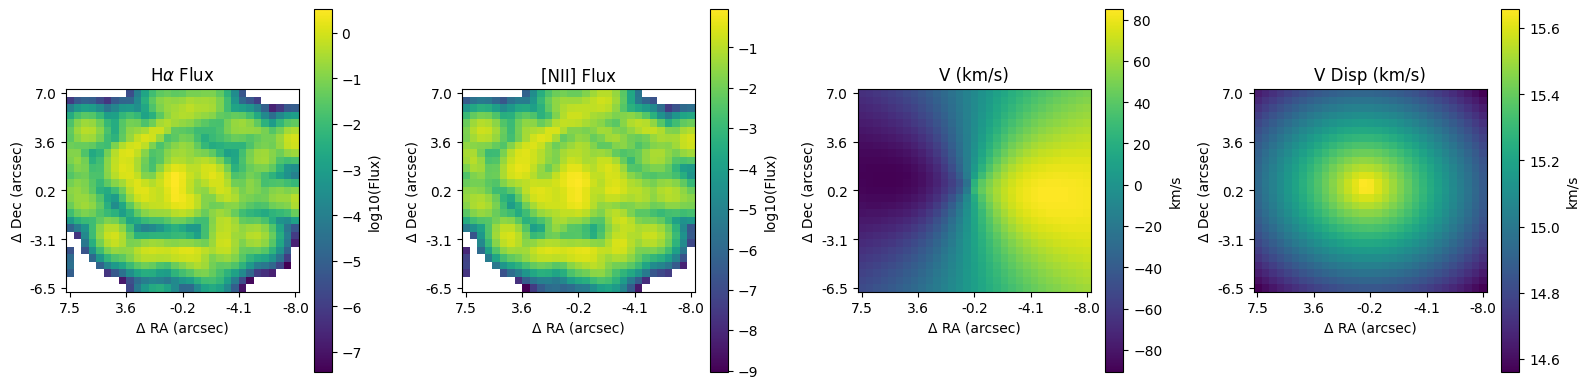

In [391]:
# plot maps for sample - now supporting multiple lines with coordinate axes
try:
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))

    # plot maps for all detected lines
    for line_idx in range(min(nlines, 2)):  # limit to first 2 lines for display
        if line_idx == 0:
            # first line - typically h-alpha
            main_wave = emission_lines[0][0] if emission_lines else 6562.81
            if abs(main_wave - 6562.81) < 0.1:
                title = r'H$\alpha$ Flux'
            else:
                title = f'Line 1 ({main_wave:.1f} Å) Flux'
        elif line_idx == 1:
            # second line - typically [nii]
            main_wave = emission_lines[1][0] if len(emission_lines) > 1 else 6583.1
            if abs(main_wave - 6583.1) < 0.1:
                title = r'[NII] Flux'
            else:
                title = f'Line 2 ({main_wave:.1f} Å) Flux'
        
        ax[line_idx].set_title(title)
        flux_map = post_b3d.maps[sample, line_idx]
        # handle zero or negative fluxes in log plot
        flux_map_safe = np.where(flux_map > 0, flux_map, np.nan)
        im = ax[line_idx].imshow(
            np.log10(flux_map_safe),
            interpolation='nearest', origin='lower')
        plt.colorbar(im, ax=ax[line_idx], label='log10(Flux)')
        setup_axes_with_coordinates(ax[line_idx], coord_info)

    # if only one line detected, show placeholder for second
    if nlines < 2:
        ax[1].set_title('No Second Line')
        ax[1].text(0.5, 0.5, 'N/A', ha='center', va='center', transform=ax[1].transAxes)
        ax[1].set_xticks([])
        ax[1].set_yticks([])

    ax[2].set_title('V (km/s)')
    im2 = ax[2].imshow(post_b3d.maps[sample, nlines], interpolation='nearest', origin='lower')
    plt.colorbar(im2, ax=ax[2], label='km/s')
    setup_axes_with_coordinates(ax[2], coord_info)

    ax[3].set_title('V Disp (km/s)')
    im3 = ax[3].imshow(post_b3d.maps[sample, nlines+1], interpolation='nearest', origin='lower')
    plt.colorbar(im3, ax=ax[3], label='km/s')
    setup_axes_with_coordinates(ax[3], coord_info)

    fig.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating initial plots: {e}")

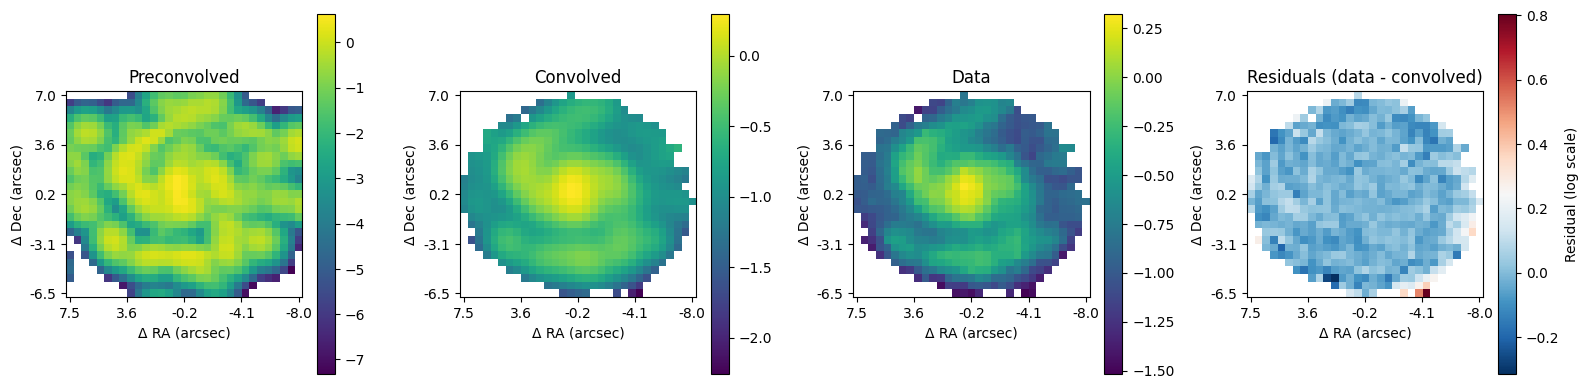

In [392]:
try:
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))

    ax[0].set_title('Preconvolved')
    preconv_sum = post_b3d.precon_cubes[sample].sum(axis=2)
    preconv_sum_safe = np.where(preconv_sum > 0, preconv_sum, np.nan)
    im0 = ax[0].imshow(np.log10(preconv_sum_safe), interpolation='nearest', origin='lower')
    plt.colorbar(im0, ax=ax[0])
    setup_axes_with_coordinates(ax[0], coord_info)

    ax[1].set_title('Convolved')
    conv_sum = post_b3d.con_cubes[sample].sum(axis=2)
    conv_sum_safe = np.where(conv_sum > 0, conv_sum, np.nan)
    im1 = ax[1].imshow(np.log10(conv_sum_safe), interpolation='nearest', origin='lower')
    plt.colorbar(im1, ax=ax[1])
    setup_axes_with_coordinates(ax[1], coord_info)

    ax[2].set_title('Data')
    data_sum = post_b3d.data.sum(axis=2)
    data_sum_safe = np.where(data_sum > 0, data_sum, np.nan)
    im2 = ax[2].imshow(np.log10(data_sum_safe), interpolation='nearest', origin='lower')
    plt.colorbar(im2, ax=ax[2])
    setup_axes_with_coordinates(ax[2], coord_info)

    ax[3].set_title('Residuals (data - convolved)')
    residual_map = (np.log10(data_sum_safe) - np.log10(conv_sum_safe))
    im3 = ax[3].imshow(residual_map, interpolation='nearest', origin='lower', cmap='RdBu_r')
    # add colorbar to make sure the centre is white
    cbar = plt.colorbar(im3, ax=ax[3])
    cbar.set_label('Residual (log scale)')
    setup_axes_with_coordinates(ax[3], coord_info)

    fig.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating flux comparison plots: {e}")

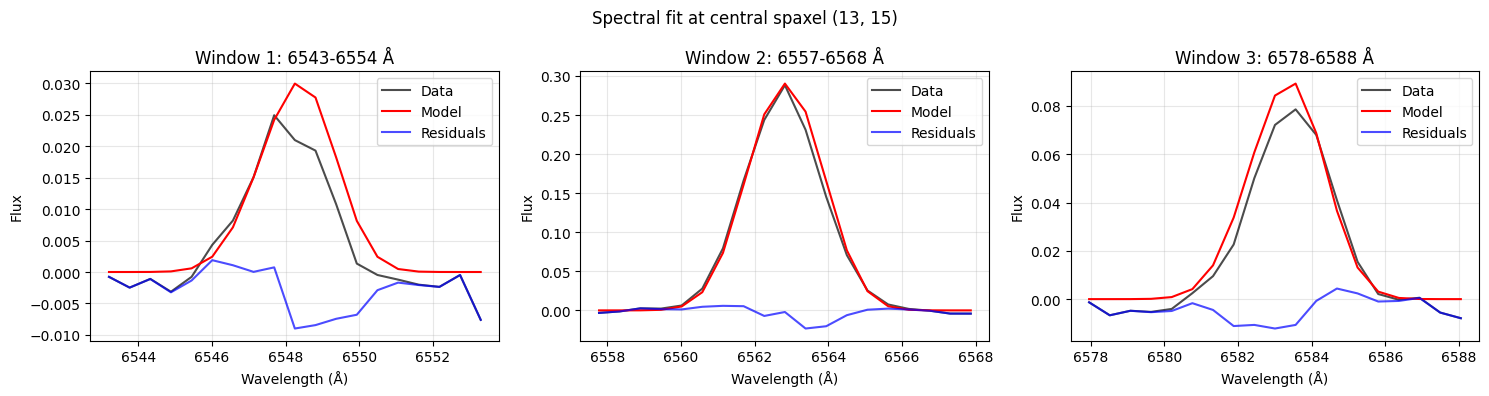

In [393]:
# plot showing the residuals at each central line location for all windows
if len(wavelength_windows) > 0:
    try:
        fig, axes = plt.subplots(1, len(wavelength_windows), figsize=(5*len(wavelength_windows), 4))
        if len(wavelength_windows) == 1:
            axes = [axes]

        central_i, central_j = post_b3d.data.shape[0]//2, post_b3d.data.shape[1]//2

        for w, window in enumerate(wavelength_windows):
            # find the wavelength indices for this window more carefully
            r_full = post_b3d.metadata.r_full
            
            # find indices within this window's range
            window_mask = (r_full >= window['r_min']) & (r_full <= window['r_max'])
            window_indices = np.where(window_mask)[0]
            
            if len(window_indices) == 0:
                # no data in this window
                axes[w].text(0.5, 0.5, 'No data\nin window', ha='center', va='center', 
                            transform=axes[w].transAxes)
                axes[w].set_title(f'Window {w+1}: {window["r_min"]:.0f}-{window["r_max"]:.0f} Å')
                continue
            
            wavelengths = r_full[window_indices]
            data_spectrum = post_b3d.data[central_i, central_j, window_indices]
            model_spectrum = post_b3d.con_cubes[sample, central_i, central_j, window_indices]
            residuals = data_spectrum - model_spectrum
            
            axes[w].plot(wavelengths, data_spectrum, 'k-', label='Data', alpha=0.7, linewidth=1.5)
            axes[w].plot(wavelengths, model_spectrum, 'r-', label='Model', linewidth=1.5)
            axes[w].plot(wavelengths, residuals, 'b-', label='Residuals', alpha=0.7)
            
            axes[w].set_xlabel('Wavelength (Å)')
            axes[w].set_ylabel('Flux')
            axes[w].set_title(f'Window {w+1}: {window["r_min"]:.0f}-{window["r_max"]:.0f} Å')
            axes[w].legend()
            axes[w].grid(True, alpha=0.3)

        fig.suptitle(f'Spectral fit at central spaxel ({central_i}, {central_j})')
        fig.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating spectral fit plots: {e}")

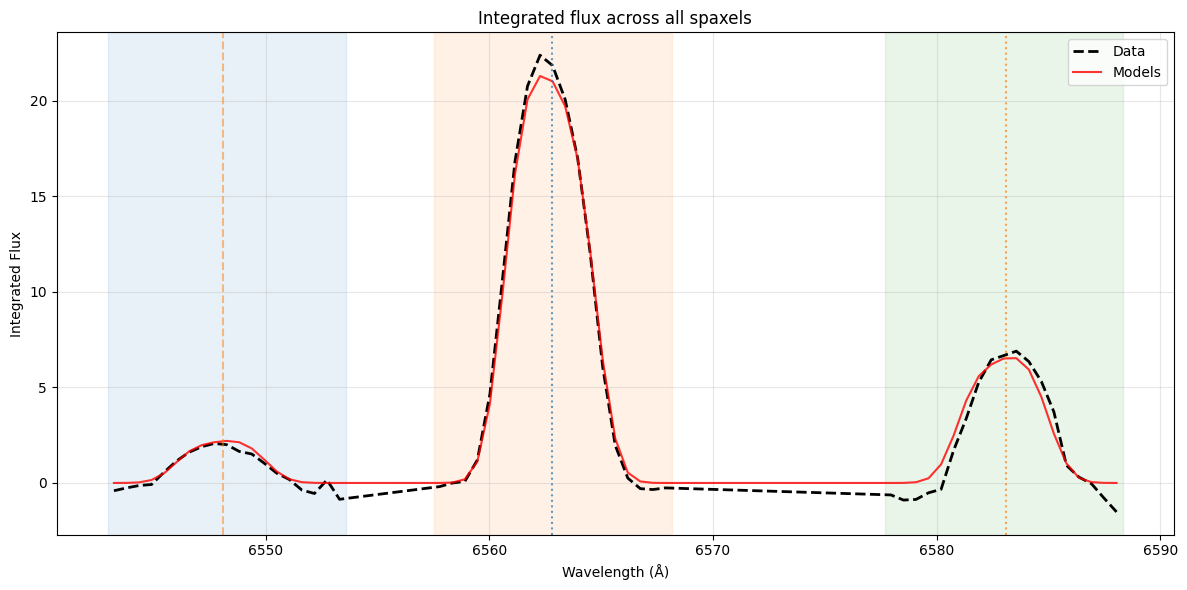

In [394]:
# plot integrated spectrum
try:
    fig, ax = plt.subplots(figsize=(12, 6))

    # plot data
    ax.plot(post_b3d.metadata.r_full, post_b3d.data.sum(axis=(0, 1)), 
            '--k', label='Data', linewidth=2)

    # plot model samples
    n_samples_to_plot = min(5, post_b3d.con_cubes.shape[0])
    for s in range(n_samples_to_plot):
        alpha = 0.3 if s > 0 else 0.8
        label = 'Models' if s == 0 else None
        ax.plot(post_b3d.metadata.r_full, post_b3d.con_cubes[s].sum(axis=(0, 1)), 
                color='red', alpha=alpha, label=label)

    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Integrated Flux')
    ax.set_title('Integrated flux across all spaxels')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # highlight wavelength windows
    y_min, y_max = ax.get_ylim()
    for w, window in enumerate(wavelength_windows):
        color = f'C{w % 10}'  # cycle through colours
        ax.axvspan(window['r_min'], window['r_max'], alpha=0.1, 
                   color=color, label=f'Window {w+1}' if w < 5 else None)

    # add vertical lines for emission lines
    for i, line in enumerate(emission_lines):
        main_wave = line[0]
        ax.axvline(main_wave, color=f'C{i % 10}', linestyle=':', alpha=0.7, 
                   label=f'Line {i+1}: {main_wave:.1f} Å' if i < 3 else None)
        
        # add coupled lines
        if len(line) > 1:
            for j in range(1, len(line), 2):
                if j+1 < len(line):
                    coupled_wave = line[j]
                    ax.axvline(coupled_wave, color=f'C{i % 10}', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating integrated spectrum plot: {e}")

In [395]:
print(lsf_fwhm_map)
print(emission_lines)

{0: 1.61, 1: 1.61, 2: 1.61}
[[6562.81], [6583.1, 6548.1, 0.33333]]


In [396]:
# create SpectralModel with validation
sm = create_spectral_model_with_validation(emission_lines, lsf_fwhm_map, post_b3d.metadata)



SpectralModel Line Configuration:
Number of line groups: 2

Line Group 1:
  Main wavelength: 6562.81 Å
  No coupled lines

Line Group 2:
  Main wavelength: 6583.10 Å
  Coupled lines:
    6548.10 Å (ratio: 0.3333)

LSF FWHM per window:
  Window 0: 1.610 Å
  Window 1: 1.610 Å
  Window 2: 1.610 Å

✓ All emission lines are within the wavelength windows


In [ ]:
# Add this debugging code to your existing script after creating the SpectralModel

def debug_moments_fitting(sm, wave, data, var, coord_info, wavelength_windows, emission_lines):
    """Debug the moments fitting to understand velocity dispersion differences."""
    
    print("\n" + "="*60)
    print("DEBUGGING MOMENTS FITTING")
    print("="*60)
    
    # Get central spaxel for debugging
    ni, nj = data.shape[:2]
    central_i, central_j = ni//2, nj//2
    
    print(f"Debugging central spaxel: ({central_i}, {central_j})")
    print(f"Data shape: {data.shape}")
    print(f"Wave range: {wave.min():.1f} - {wave.max():.1f} Å")
    
    # Extract spectrum for central spaxel
    spectrum = data[central_i, central_j, :]
    variance = var[central_i, central_j, :] if var is not None else None
    
    print(f"Spectrum stats: min={np.nanmin(spectrum):.2e}, max={np.nanmax(spectrum):.2e}, mean={np.nanmean(spectrum):.2e}")
    
    # Test the guess function with debugging
    print("\n" + "-"*40)
    print("TESTING MOMENTS ESTIMATION")
    print("-"*40)
    
    # Call the internal _guess method with debugging
    guess = sm._guess(wave, spectrum, lambda_win=10.0)
    print(f"Moments guess: {guess}")
    
    # Let's also test the new windowed parameter estimation
    for i, line in enumerate(emission_lines):
        print(f"\nLine {i+1}: {line}")
        
        # Test the windowed estimation for this line
        flux_est, vel_est, vdisp_est = sm._estimate_line_parameters_windowed(
            wave, spectrum, line, lambda_win=10.0)
        
        print(f"  Windowed estimates: flux={flux_est}, vel={vel_est:.2f} km/s, vdisp={vdisp_est:.2f} km/s")
        
        # Find which window this line belongs to
        window_idx = sm._find_window_for_wavelength(line[0])
        print(f"  Line belongs to window: {window_idx}")
        
        if window_idx is not None and wavelength_windows:
            window = wavelength_windows[window_idx]
            print(f"  Window range: {window['r_min']:.1f} - {window['r_max']:.1f} Å")
            print(f"  Window LSF FWHM: {window['lsf_fwhm']:.3f} Å")
        
        # Get window mask and show how much data is available
        if window_idx is not None:
            window_mask = sm._get_window_wavelength_mask(wave, window_idx)
            line_region_mask = np.abs(wave - line[0]) <= 10.0
            final_mask = window_mask & line_region_mask
            
            print(f"  Window mask: {np.sum(window_mask)} pixels")
            print(f"  Line region mask: {np.sum(line_region_mask)} pixels") 
            print(f"  Combined mask: {np.sum(final_mask)} pixels")
            
            if np.any(final_mask):
                wave_win = wave[final_mask]
                data_win = spectrum[final_mask]
                finite_mask = np.isfinite(data_win) & (data_win > 0)
                
                print(f"  Valid data points: {np.sum(finite_mask)} / {len(data_win)}")
                if np.any(finite_mask):
                    data_clean = data_win[finite_mask]
                    wave_clean = wave_win[finite_mask]
                    print(f"  Data range in window: {np.min(data_clean):.2e} - {np.max(data_clean):.2e}")
                    print(f"  Wave range in window: {wave_clean.min():.1f} - {wave_clean.max():.1f} Å")
    
    # Now let's compare with the old method
    print("\n" + "-"*40)
    print("COMPARISON WITH OLD METHOD")
    print("-"*40)
    
    # Simulate the old method behavior - treat all wavelengths as continuous
    old_style_estimates = []
    
    for i, line in enumerate(emission_lines):
        line_wave = line[0]
        lambda_win = 10.0
        
        # Old style - no windowing, just wavelength proximity
        win = np.abs(wave - line_wave) <= lambda_win
        
        if np.any(win):
            win_data = spectrum[win]
            win_wave = wave[win]
            
            finite_mask = np.isfinite(win_data) & (win_data > 0)
            if np.any(finite_mask):
                data_clean = win_data[finite_mask]
                wave_clean = win_wave[finite_mask]
                
                # Old style flux estimate
                dwave = np.median(np.diff(wave_clean)) if len(wave_clean) > 1 else 1.0
                flux_old = np.sum(data_clean) * dwave
                
                # Old style velocity estimate
                weights = data_clean - np.min(data_clean)
                weights = np.maximum(weights, 1e-10)
                mean_wave = np.average(wave_clean, weights=weights)
                vel_old = (mean_wave / line_wave - 1.0) * 299792.458  # PhysicalConstants.C
                
                # Old style velocity dispersion - using global LSF
                lsf_sigma_old = sm.lsf_sigma  # global LSF
                var_wave = np.average((wave_clean - mean_wave)**2, weights=weights)
                var_wave = max(0, var_wave - lsf_sigma_old**2)
                vdisp_old = max(1.0, np.sqrt(var_wave) * 299792.458 / line_wave)
                
                old_style_estimates.append((flux_old, vel_old, vdisp_old))
                print(f"Line {i+1} old style: flux={flux_old:.2e}, vel={vel_old:.2f} km/s, vdisp={vdisp_old:.2f} km/s")
            else:
                old_style_estimates.append((None, None, None))
                print(f"Line {i+1} old style: no valid data")
        else:
            old_style_estimates.append((None, None, None))
            print(f"Line {i+1} old style: no data in window")
    
    # Fit the actual spaxel and compare
    print("\n" + "-"*40)
    print("ACTUAL FIT RESULTS")
    print("-"*40)
    
    popt, pcov = sm.fit_spaxel(wave, spectrum, variance)
    print(f"Fit results: {popt}")
    print(f"Fit errors: {np.sqrt(np.abs(pcov))}")
    
    if len(popt) >= sm.nlines + 2:
        print(f"Fitted velocity: {popt[sm.nlines]:.2f} km/s")
        print(f"Fitted velocity dispersion: {popt[sm.nlines+1]:.2f} km/s")
    
    # Test a few more spaxels to see if there's a pattern
    print("\n" + "-"*40)
    print("TESTING MULTIPLE SPAXELS")
    print("-"*40)
    
    test_positions = [
        (ni//4, nj//4),      # bottom-left
        (ni//4, 3*nj//4),    # bottom-right  
        (3*ni//4, nj//4),    # top-left
        (3*ni//4, 3*nj//4),  # top-right
        (ni//2, nj//2)       # centre
    ]
    
    for pos_i, pos_j in test_positions:
        test_spectrum = data[pos_i, pos_j, :]
        test_variance = var[pos_i, pos_j, :] if var is not None else None
        
        test_popt, test_pcov = sm.fit_spaxel(wave, test_spectrum, test_variance)
        
        if len(test_popt) >= sm.nlines + 2:
            vel_fit = test_popt[sm.nlines]
            vdisp_fit = test_popt[sm.nlines+1]
            print(f"Position ({pos_i:2d},{pos_j:2d}): v={vel_fit:6.2f} km/s, σv={vdisp_fit:5.2f} km/s")
            
            # Also test the moments estimate
            test_guess = sm._guess(wave, test_spectrum)
            if len(test_guess) >= sm.nlines + 2:
                vel_guess = test_guess[sm.nlines]
                vdisp_guess = test_guess[sm.nlines+1]
                print(f"              guess: v={vel_guess:6.2f} km/s, σv={vdisp_guess:5.2f} km/s")
    
    return guess, popt, pcov

# Add this to your script after creating the SpectralModel
if sm is not None:
    debug_results = debug_moments_fitting(
        sm, 
        post_b3d.metadata.get_axis_array('r'), 
        post_b3d.data, 
        post_b3d.var,
        coord_info,
        wavelength_windows,
        emission_lines
    )

In [397]:
# fit the data cube if spectral model was created successfully
fit = None
fit_err = None

if sm is not None:
    try:
        print("Fitting data cube...")
        wave = post_b3d.metadata.get_axis_array('r')
        fit, fit_err = sm.fit_cube(wave, post_b3d.data, post_b3d.var)
        print(f"Fit successful. Fit shape: {fit.shape}")
    except Exception as e:
        print(f"Error fitting cube: {e}")
        print("Continuing without fit results...")


Fitting data cube...
Fit successful. Fit shape: (4, 27, 31)


In [ ]:
# Add this analysis code after your fitting

def analyze_velocity_dispersion_differences(post_b3d, fit, sample, nlines, aligned_vdisp):
    """Analyze the differences in velocity dispersion between model and fitted data."""
    
    print("\n" + "="*60)
    print("VELOCITY DISPERSION ANALYSIS")
    print("="*60)
    
    # Get the different velocity dispersion maps
    vdisp_model = post_b3d.maps[sample, nlines + 1]  # preconvolved model
    vdisp_fitted = fit[nlines + 1] if fit is not None and fit.shape[0] > nlines + 1 else None
    vdisp_data = aligned_vdisp
    
    print(f"Model vdisp shape: {vdisp_model.shape}")
    if vdisp_fitted is not None:
        print(f"Fitted vdisp shape: {vdisp_fitted.shape}")
    if vdisp_data is not None:
        print(f"Data vdisp shape: {vdisp_data.shape}")
    
    # Statistics for each map
    def get_stats(arr, name):
        if arr is not None:
            valid_mask = np.isfinite(arr) & (arr > 0)
            if np.any(valid_mask):
                valid_data = arr[valid_mask]
                print(f"\n{name} statistics:")
                print(f"  Valid pixels: {np.sum(valid_mask)} / {arr.size}")
                print(f"  Range: {np.min(valid_data):.2f} - {np.max(valid_data):.2f} km/s")
                print(f"  Mean: {np.mean(valid_data):.2f} km/s")
                print(f"  Median: {np.median(valid_data):.2f} km/s")
                print(f"  Std: {np.std(valid_data):.2f} km/s")
                
                # Percentiles
                percentiles = [10, 25, 50, 75, 90]
                pvals = np.percentile(valid_data, percentiles)
                print(f"  Percentiles: {dict(zip(percentiles, pvals))}")
                
                return valid_data
            else:
                print(f"\n{name}: No valid data")
                return None
        else:
            print(f"\n{name}: Data not available")
            return None
    
    model_valid = get_stats(vdisp_model, "Model (preconvolved)")
    fitted_valid = get_stats(vdisp_fitted, "Fitted (convolved)") 
    data_valid = get_stats(vdisp_data, "Data (external)")
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Histograms
    if model_valid is not None:
        axes[0, 0].hist(model_valid, bins=50, alpha=0.7, label='Model', color='blue')
        axes[0, 0].set_title('Model Vdisp Distribution')
        axes[0, 0].set_xlabel('Velocity Dispersion (km/s)')
        axes[0, 0].set_ylabel('Count')
    
    if fitted_valid is not None:
        axes[0, 1].hist(fitted_valid, bins=50, alpha=0.7, label='Fitted', color='red')
        axes[0, 1].set_title('Fitted Vdisp Distribution')
        axes[0, 1].set_xlabel('Velocity Dispersion (km/s)')
        axes[0, 1].set_ylabel('Count')
    
    if data_valid is not None:
        axes[0, 2].hist(data_valid, bins=50, alpha=0.7, label='Data', color='green')
        axes[0, 2].set_title('Data Vdisp Distribution')
        axes[0, 2].set_xlabel('Velocity Dispersion (km/s)')
        axes[0, 2].set_ylabel('Count')
    
    # Scatter plots comparing them
    if model_valid is not None and fitted_valid is not None:
        # Make sure arrays are same size for comparison
        common_mask = np.isfinite(vdisp_model) & np.isfinite(vdisp_fitted) & (vdisp_model > 0) & (vdisp_fitted > 0)
        if np.any(common_mask):
            model_common = vdisp_model[common_mask]
            fitted_common = vdisp_fitted[common_mask]
            
            axes[1, 0].scatter(model_common, fitted_common, alpha=0.6, s=1)
            axes[1, 0].plot([0, 100], [0, 100], 'r--', alpha=0.5)
            axes[1, 0].set_xlabel('Model Vdisp (km/s)')
            axes[1, 0].set_ylabel('Fitted Vdisp (km/s)')
            axes[1, 0].set_title('Model vs Fitted Vdisp')
            axes[1, 0].grid(True, alpha=0.3)
            
            # Calculate correlation
            correlation = np.corrcoef(model_common, fitted_common)[0, 1]
            axes[1, 0].text(0.05, 0.95, f'R = {correlation:.3f}', 
                           transform=axes[1, 0].transAxes, 
                           bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    if fitted_valid is not None and data_valid is not None:
        # Compare fitted vs external data
        common_mask = np.isfinite(vdisp_fitted) & np.isfinite(vdisp_data) & (vdisp_fitted > 0) & (vdisp_data > 0)
        if np.any(common_mask):
            fitted_common = vdisp_fitted[common_mask]
            data_common = vdisp_data[common_mask]
            
            axes[1, 1].scatter(fitted_common, data_common, alpha=0.6, s=1)
            axes[1, 1].plot([0, 100], [0, 100], 'r--', alpha=0.5)
            axes[1, 1].set_xlabel('Fitted Vdisp (km/s)')
            axes[1, 1].set_ylabel('Data Vdisp (km/s)')
            axes[1, 1].set_title('Fitted vs Data Vdisp')
            axes[1, 1].grid(True, alpha=0.3)
            
            # Calculate correlation
            correlation = np.corrcoef(fitted_common, data_common)[0, 1]
            axes[1, 1].text(0.05, 0.95, f'R = {correlation:.3f}', 
                           transform=axes[1, 1].transAxes,
                           bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    if model_valid is not None and data_valid is not None:
        # Compare model vs external data
        common_mask = np.isfinite(vdisp_model) & np.isfinite(vdisp_data) & (vdisp_model > 0) & (vdisp_data > 0)
        if np.any(common_mask):
            model_common = vdisp_model[common_mask]
            data_common = vdisp_data[common_mask]
            
            axes[1, 2].scatter(model_common, data_common, alpha=0.6, s=1)
            axes[1, 2].plot([0, 100], [0, 100], 'r--', alpha=0.5)
            axes[1, 2].set_xlabel('Model Vdisp (km/s)')
            axes[1, 2].set_ylabel('Data Vdisp (km/s)')
            axes[1, 2].set_title('Model vs Data Vdisp')
            axes[1, 2].grid(True, alpha=0.3)
            
            # Calculate correlation
            correlation = np.corrcoef(model_common, data_common)[0, 1]
            axes[1, 2].text(0.05, 0.95, f'R = {correlation:.3f}', 
                           transform=axes[1, 2].transAxes,
                           bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Check if there are systematic differences in different regions
    print("\n" + "-"*40)
    print("REGIONAL ANALYSIS")
    print("-"*40)
    
    if vdisp_fitted is not None:
        # Divide image into regions and check statistics
        ni, nj = vdisp_fitted.shape
        
        regions = [
            ("Centre", slice(ni//3, 2*ni//3), slice(nj//3, 2*nj//3)),
            ("Edges", slice(0, ni//4), slice(0, nj)),  # top edge
            ("Bottom", slice(3*ni//4, ni), slice(0, nj)),  # bottom edge
            ("Left", slice(0, ni), slice(0, nj//4)),  # left edge
            ("Right", slice(0, ni), slice(3*nj//4, nj))  # right edge
        ]
        
        for region_name, i_slice, j_slice in regions:
            region_data = vdisp_fitted[i_slice, j_slice]
            valid_mask = np.isfinite(region_data) & (region_data > 0)
            
            if np.any(valid_mask):
                valid_values = region_data[valid_mask]
                print(f"{region_name}: mean={np.mean(valid_values):.2f}, "
                      f"std={np.std(valid_values):.2f}, "
                      f"n={len(valid_values)}")

# Run the analysis
if fit is not None and aligned_vdisp is not None:
    analyze_velocity_dispersion_differences(post_b3d, fit, sample, nlines, aligned_vdisp)

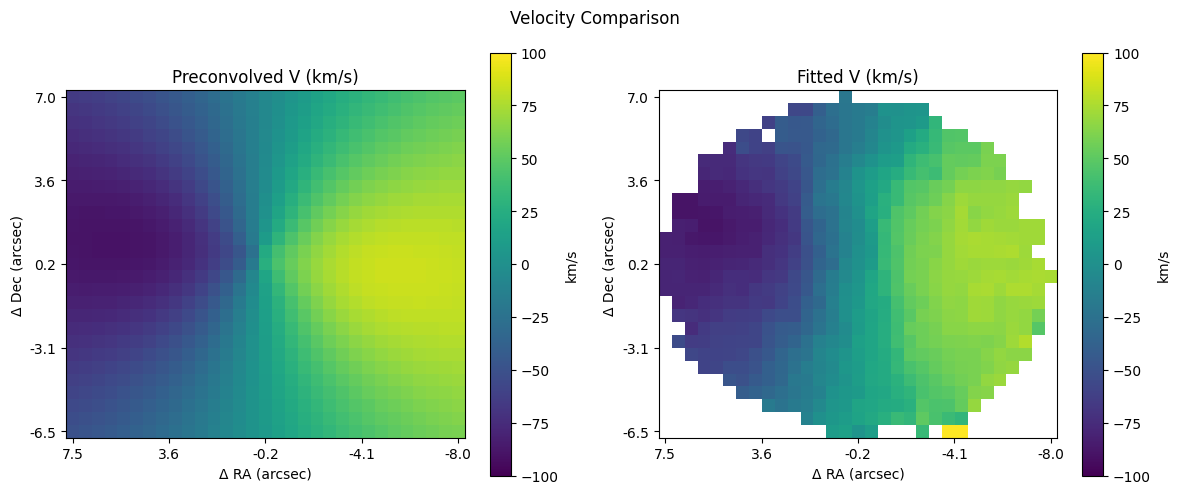

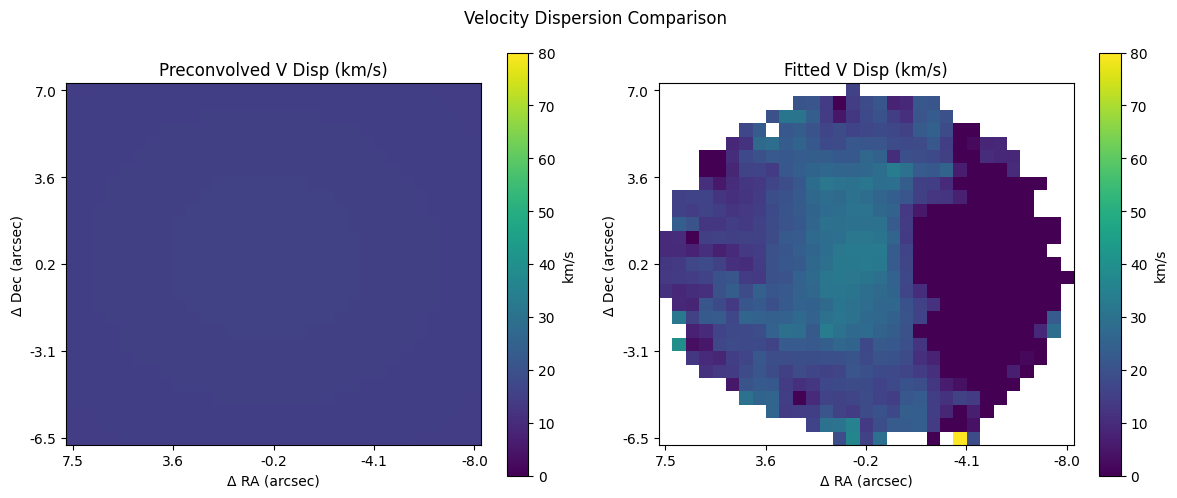

In [398]:
# velocity comparison plots
try:
    # velocity comparison
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Velocity Comparison')

    v_map_idx = nlines 

    # preconvolved velocity
    vmin, vmax = -100, 100
    im1 = ax[0].imshow(post_b3d.maps[sample, v_map_idx], vmin=vmin, vmax=vmax, 
                       origin='lower', cmap='viridis')
    ax[0].set_title('Preconvolved V (km/s)')
    plt.colorbar(im1, ax=ax[0], label='km/s')
    setup_axes_with_coordinates(ax[0], coord_info)

    # fitted velocity from convolved data
    if fit is not None and fit.shape[0] > 2:  # ensure we have velocity in fit results
        im2 = ax[1].imshow(fit[2], vmin=vmin, vmax=vmax, origin='lower', cmap='viridis')
        ax[1].set_title('Fitted V (km/s)')
        plt.colorbar(im2, ax=ax[1], label='km/s')
        setup_axes_with_coordinates(ax[1], coord_info)
    else:
        ax[1].text(0.5, 0.5, 'Fit failed\nor insufficient\nparameters', 
                   ha='center', va='center', transform=ax[1].transAxes)
        ax[1].set_title('Fitted V (Failed)')

    fig.tight_layout()
    plt.show()

    # velocity dispersion comparison
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Velocity Dispersion Comparison')

    vdisp_map_idx = nlines + 1  # velocity dispersion is after flux and velocity maps

    # preconvolved velocity dispersion
    vmin, vmax = 0.0, 80.0
    im1 = ax[0].imshow(post_b3d.maps[sample, vdisp_map_idx], vmin=vmin, vmax=vmax, 
                       origin='lower', cmap='viridis')
    ax[0].set_title('Preconvolved V Disp (km/s)')
    plt.colorbar(im1, ax=ax[0], label='km/s')
    setup_axes_with_coordinates(ax[0], coord_info)

    # fitted velocity dispersion from convolved data
    if fit is not None and fit.shape[0] > 3:  # ensure we have velocity dispersion in fit results
        im2 = ax[1].imshow(fit[3], vmin=vmin, vmax=vmax, origin='lower', cmap='viridis')
        ax[1].set_title('Fitted V Disp (km/s)')
        plt.colorbar(im2, ax=ax[1], label='km/s')
        setup_axes_with_coordinates(ax[1], coord_info)
    else:
        ax[1].text(0.5, 0.5, 'Fit failed\nor insufficient\nparameters', 
                   ha='center', va='center', transform=ax[1].transAxes)
        ax[1].set_title('Fitted V Disp (Failed)')

    fig.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating velocity comparison plots: {e}")

In [399]:
# reading velocity data
data_v_2d, data_vdisp_2d = read_velocity_data(data_file)

Reading velocity data from: /Users/scol0322/Documents/raw-data/485885/485885_8_Y13SAR1_P007_15T010_2013_03_05-2013_03_17_1_comp.fits
Available FITS extensions:
  0: PRIMARY - PrimaryHDU
  1: B_CONTINUUM - ImageHDU
  2: R_CONTINUUM - ImageHDU
  3: B_LINE - ImageHDU
  4: R_LINE - ImageHDU
  5: B_LINE_COMP1 - ImageHDU
  6: R_LINE_COMP1 - ImageHDU
  7: V - ImageHDU
  8: V_ERR - ImageHDU
  9: VDISP - ImageHDU
  10: VDISP_ERR - ImageHDU
  11: CHI2 - ImageHDU
  12: DOF - ImageHDU
  13: OII3726 - ImageHDU
  14: OII3726_ERR - ImageHDU
  15: OII3729 - ImageHDU
  16: OII3729_ERR - ImageHDU
  17: HBETA - ImageHDU
  18: HBETA_ERR - ImageHDU
  19: OIII5007 - ImageHDU
  20: OIII5007_ERR - ImageHDU
  21: OI6300 - ImageHDU
  22: OI6300_ERR - ImageHDU
  23: HALPHA - ImageHDU
  24: HALPHA_ERR - ImageHDU
  25: NII6583 - ImageHDU
  26: NII6583_ERR - ImageHDU
  27: SII6716 - ImageHDU
  28: SII6716_ERR - ImageHDU
  29: SII6731 - ImageHDU
  30: SII6731_ERR - ImageHDU
Velocity cube shape: (2, 50, 50)
Velocity 

In [400]:
print(coord_info)

{'ni': 27.0, 'nj': 31.0, 'x_min': -7.5, 'x_max': 8.0, 'y_min': -6.5, 'y_max': 7.0}


In [401]:

def align_velocity_data(data_2d, model_2d, coord_info):
    """align velocity data with PostBlobby3D maps."""
    if data_2d is None or model_2d is None:
        print("Error: No velocity data available for alignment")
        return None
    try:
        x_range = [coord_info.get('x_min'), coord_info.get('x_max')]
        y_range = [coord_info.get('y_min'), coord_info.get('y_max')]

        x_arcsec_per_pix = (x_range[1] - x_range[0]) / coord_info.get('nj')
        y_arcsec_per_pix = (y_range[1] - y_range[0]) / coord_info.get('ni')

        data_shape = data_2d.shape

        x_range_data = [-data_shape[0]/2 * x_arcsec_per_pix,
                        data_shape[0]/2 * x_arcsec_per_pix]
        y_range_data = [-data_shape[1]/2 * y_arcsec_per_pix,
                        data_shape[1]/2 * y_arcsec_per_pix]
        
        print(f"Aligning velocity data with ranges: {x_range_data}, {y_range_data}")

        #check data range is larger than model range
        if (x_range_data[0] > x_range[0] or x_range_data[1] < x_range[1] or
            y_range_data[0] > y_range[0] or y_range_data[1] < y_range[1]):
            print("Error: Data range is smaller than model range, cannot align")
            return None 

        # indexes to remove from the data
        x_start = abs(int((x_range_data[0] - x_range[0]) / x_arcsec_per_pix))
        x_end = 50 - abs(int((x_range_data[1] - x_range[1]) / x_arcsec_per_pix))
        y_start = abs(int((y_range_data[1] - y_range[1]) / y_arcsec_per_pix))
        y_end = 50 - abs(int((y_range_data[0] - y_range[0]) / y_arcsec_per_pix))
        print(f"Data slice: x[{x_start}:{x_end}], y[{y_start}:{y_end}]")    

        # slice the data to match the model
        # flipped for some reason
        aligned_data = data_2d[y_start:y_end, x_start:x_end]

        if aligned_data.shape != model_2d.shape:
            print(f"Error: Aligned data shape {aligned_data.shape} does not match model shape {model_2d.shape}")
            return None
        
        return aligned_data

    except Exception as e:
        print(f"Error aligning velocity data: {e}")
        return None

aligned_v = align_velocity_data(data_v_2d, fit[2], coord_info)
aligned_vdisp = align_velocity_data(data_vdisp_2d, fit[3], coord_info)

Aligning velocity data with ranges: [-12.5, 12.5], [-12.5, 12.5]
Data slice: x[10:41], y[11:38]
Aligning velocity data with ranges: [-12.5, 12.5], [-12.5, 12.5]
Data slice: x[10:41], y[11:38]


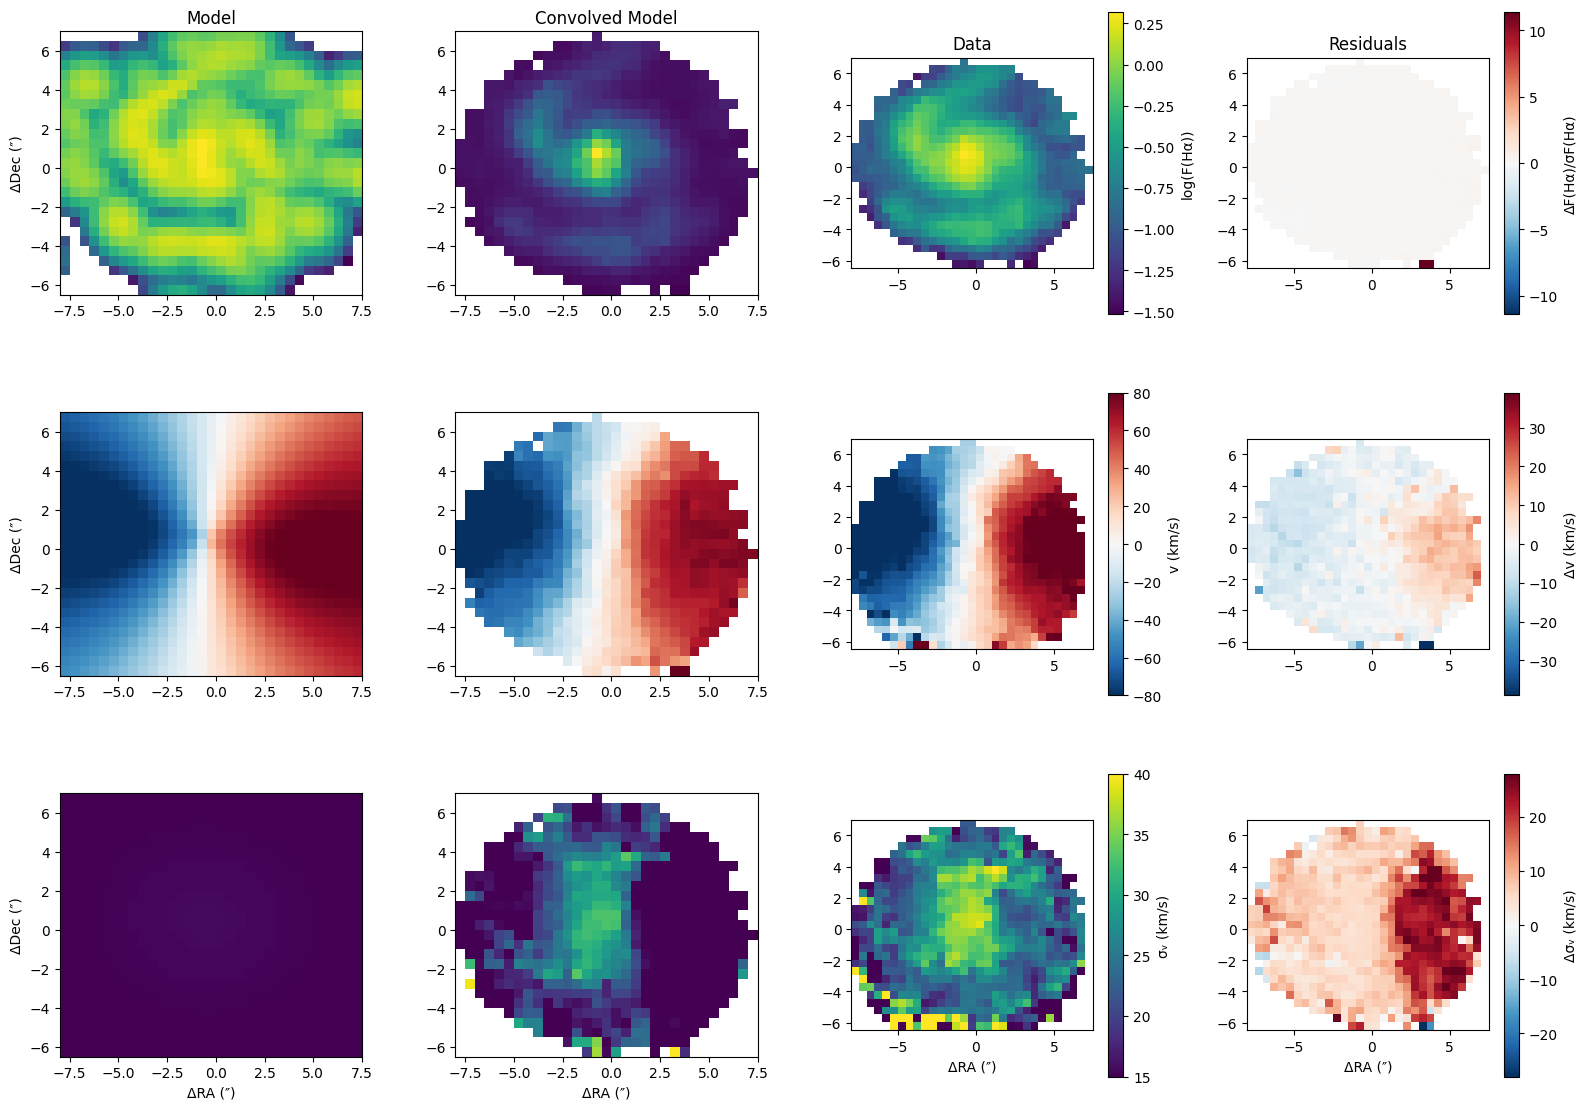

In [402]:
def create_comprehensive_comparison_plot(post_b3d, fit, sample, nlines, coord_info, vdisp_data, v_data):
    """create a comprehensive 4x3 comparison plot."""
    
    try:
        # set up the figure
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        fig.subplots_adjust(hspace=0.3, wspace=0.3)
        
        # get the data shapes and coordinate setup
        ni, nj = post_b3d.data.shape[:2]
        
        # create coordinate arrays for proper axis labelling
        if coord_info:
            x_min = coord_info.get('x_min')
            x_max = coord_info.get('x_max') 
            y_min = coord_info.get('y_min')
            y_max = coord_info.get('y_max')
            # note: ra increases to the left (negative direction)
            extent = [-x_max, -x_min, y_min, y_max]
        else:
            extent = [0, nj-1, 0, ni-1]
        
        # row 1: flux (hα - first emission line)
        row = 0
        
        # model (preconvolved)
        flux_model = post_b3d.maps[sample, 0]  # first line flux
        flux_model_safe = np.where(flux_model > 0, flux_model, np.nan)
        im1 = axes[row, 0].imshow(np.log10(flux_model_safe), extent=extent, 
                                 origin='lower', cmap='viridis')
        axes[row, 0].set_title('Model')
        axes[row, 0].set_ylabel('ΔDec (″)')
        
        # convolved model  
        flux_conv = fit[0] #post_b3d.con_cubes[sample].sum(axis=2)  # integrate over wavelength
        flux_conv_safe = np.where(flux_conv > 0, flux_conv, np.nan)
        im2 = axes[row, 1].imshow(flux_conv_safe, extent=extent,
                                 origin='lower', cmap='viridis')
        axes[row, 1].set_title('Convolved Model')
        
        # data
        flux_data = post_b3d.data.sum(axis=2)  # integrate over wavelength
        flux_data_safe = np.where(flux_data > 0, flux_data, np.nan)
        im3 = axes[row, 2].imshow(np.log10(flux_data_safe), extent=extent,
                                 origin='lower', cmap='viridis')
        axes[row, 2].set_title('Data')
        
        # residuals
        flux_residual = np.log10(flux_data_safe) - np.log10(flux_conv_safe)
        residual_std = np.nanstd(flux_residual)
        im4 = axes[row, 3].imshow(flux_residual, extent=extent, origin='lower', 
                                 cmap='RdBu_r', vmin=-3*residual_std, vmax=3*residual_std)
        axes[row, 3].set_title('Residuals')
        
        # add colorbars for flux row
        fig.colorbar(im3, ax=axes[row, 2], shrink=0.8, label='log(F(Hα))')
        fig.colorbar(im4, ax=axes[row, 3], shrink=0.8, label='ΔF(Hα)/σF(Hα)')
        
        # row 2: velocity
        row = 1
        v_map_idx = nlines  # velocity map index
        
        # model velocity
        v_model = post_b3d.maps[sample, v_map_idx]
        im5 = axes[row, 0].imshow(v_model, extent=extent, origin='lower', 
                                 cmap='RdBu_r', vmin=-80, vmax=80)
        axes[row, 0].set_ylabel('ΔDec (″)')
        
        # convolved model velocity (from fit if available)
        if fit is not None and fit.shape[0] > 2:
            v_conv = fit[2]
            im6 = axes[row, 1].imshow(v_conv, extent=extent, origin='lower',
                                     cmap='RdBu_r', vmin=-80, vmax=80)
        else:
            # fallback to model if fit failed
            im6 = axes[row, 1].imshow(v_model, extent=extent, origin='lower',
                                     cmap='RdBu_r', vmin=-80, vmax=80)
            v_conv = v_model
        
        im7 = axes[row, 2].imshow(v_data, extent=extent, origin='lower',
                                 cmap='RdBu_r', vmin=-80, vmax=80)
        
        # velocity residuals
        v_residual = v_data - v_conv
        v_res_std = np.nanstd(v_residual)
        if v_res_std > 0:
            im8 = axes[row, 3].imshow(v_residual, extent=extent, origin='lower',
                                     cmap='RdBu_r', vmin=-3*v_res_std, vmax=3*v_res_std)
        else:
            im8 = axes[row, 3].imshow(v_residual, extent=extent, origin='lower', cmap='RdBu_r')
        
        # add colorbars for velocity row
        fig.colorbar(im7, ax=axes[row, 2], shrink=0.8, label='v (km/s)')
        fig.colorbar(im8, ax=axes[row, 3], shrink=0.8, label='Δv (km/s)')
        
        # row 3: velocity dispersion  
        row = 2
        vdisp_map_idx = nlines + 1  # velocity dispersion map index
        
        # model velocity dispersion
        vdisp_model = post_b3d.maps[sample, vdisp_map_idx]
        im9 = axes[row, 0].imshow(vdisp_model, extent=extent, origin='lower',
                                 cmap='viridis', vmin=15, vmax=40)
        axes[row, 0].set_ylabel('ΔDec (″)')
        axes[row, 0].set_xlabel('ΔRA (″)')
        
        # convolved model velocity dispersion (from fit if available)
        if fit is not None and fit.shape[0] > 3:
            vdisp_conv = fit[3]
            im10 = axes[row, 1].imshow(vdisp_conv, extent=extent, origin='lower',
                                      cmap='viridis', vmin=15, vmax=40)
        else:
            # fallback to model if fit failed
            im10 = axes[row, 1].imshow(vdisp_model, extent=extent, origin='lower',
                                      cmap='viridis', vmin=15, vmax=40)
            vdisp_conv = vdisp_model
        
        axes[row, 1].set_xlabel('ΔRA (″)')
        
        # for "data" velocity dispersion, use fitted values
        im11 = axes[row, 2].imshow(vdisp_data, extent=extent, origin='lower',
                                  cmap='viridis', vmin=15, vmax=40)
        axes[row, 2].set_xlabel('ΔRA (″)')
        
        # velocity dispersion residuals
        vdisp_residual = vdisp_data - vdisp_conv
        vdisp_res_std = np.nanstd(vdisp_residual)
        if vdisp_res_std > 0:
            im12 = axes[row, 3].imshow(vdisp_residual, extent=extent, origin='lower',
                                      cmap='RdBu_r', vmin=-3*vdisp_res_std, vmax=3*vdisp_res_std)
        else:
            im12 = axes[row, 3].imshow(vdisp_residual, extent=extent, origin='lower', cmap='RdBu_r')
        axes[row, 3].set_xlabel('ΔRA (″)')
        
        # add colorbars for velocity dispersion row
        fig.colorbar(im11, ax=axes[row, 2], shrink=0.8, label='σᵥ (km/s)')
        fig.colorbar(im12, ax=axes[row, 3], shrink=0.8, label='Δσᵥ (km/s)')
        
        plt.tight_layout()
        plt.show()
        
        return fig, axes
        
    except Exception as e:
        print(f"Error creating comparison plot: {e}")
        return None, None

fig, axes = create_comprehensive_comparison_plot(
    post_b3d, fit, sample, nlines, coord_info, aligned_vdisp, aligned_v)